In [3]:
from sklearn.metrics import r2_score,accuracy_score
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

read data from file

In [4]:
path="C:/Users/ximil/OneDrive - International Campus, Zhejiang University/Content/BCAI4/BCAI-Workshop/BCAIW2/"
file="MNS_data_full.csv"
with open(path+file) as f:
    data= pd.read_csv(f)

#remove NA
data.dropna(inplace=True)
raw_data=data.copy()

#calculate z-score
data_zscore=(data-data.mean())/data.std()
data=data_zscore.copy()

#print example
data_zscore.head(2)

,article_id,user_id,correctness,likability,usefulness,accuracy,confidence,change_view,clarity,total_points,...,Depression,Anxiety,Extraversion,Agreeableness,Conscientiousness,Neuroticism,OpennessToExperience,HowOftenNews,TimeWeekNews,number_of_article
0,-2.061255,-1.455051,0.607972,-0.178046,-0.100488,-0.464951,0.123513,0.465802,1.149256,0.211672,...,-0.851771,0.099217,-0.386329,1.057417,1.311556,-0.574216,-0.557618,0.181495,-0.580092,0.568014
1,-2.044902,-1.455051,0.607972,-0.178046,-0.100488,-2.229155,-1.112310,-0.697233,-0.513150,0.211672,...,-0.851771,0.099217,-0.386329,1.057417,1.311556,-0.574216,-0.557618,0.181495,-0.580092,0.568014


useful function

In [5]:
def trainORtest(n):
    test_set=random.sample(range(n),n//3)
    train_set=list(set(range(n))-set(test_set))
    return train_set,test_set

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(history.history['loss'], color='blue', label='Training loss')
    ax[0].plot(history.history['val_loss'], color='orange', label='Validation loss')
    ax[0].legend()

    try:
        ax[1].plot(history.history['accuracy'], color='blue', label='Training accuracy')
        ax[1].plot(history.history['val_accuracy'], color='orange', label='Validation accuracy')
    except KeyError:
        ax[1].plot(history.history['binary_accuracy'], color='blue', label='Training binary_accuracy')
        ax[1].plot(history.history['val_binary_accuracy'], color='orange', label='Validation binary_accuracy')
    ax[1].legend()

    plt.show()

def chooser(y,k):
    index=[]
    for i in range(k):
        for j in range(1,5):
            # print(i,j)
            a=random.choice(np.arange(y.shape[0])[y//1==j])
            # print(j,a)
            index.append(a)
    return index

def plot_distrubution(y,pred,b=30):
    fig,ax=plt.subplots(1,2,sharex = True,sharey=True)
    ax[0].hist(y,bins=b)
    ax[1].hist(pred,bins=b)
    ax[0].set_title("true value")
    ax[1].set_title("prediction")

predict **correctness**

31/31 [==============================] - 0s 896us/step
r2: 0.22040429601578104


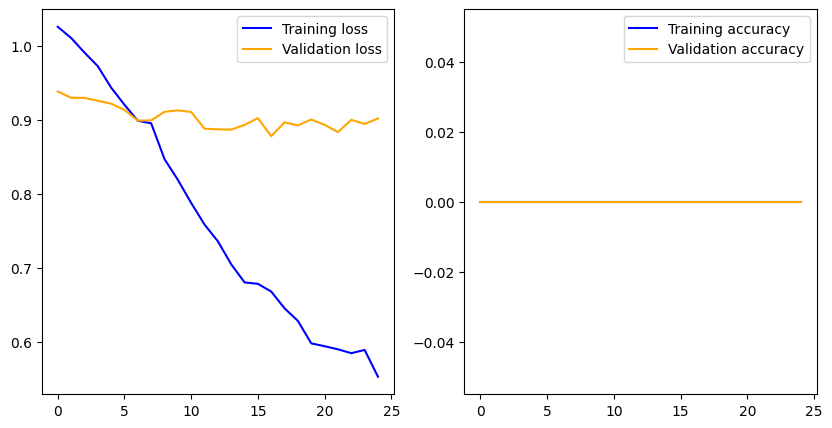

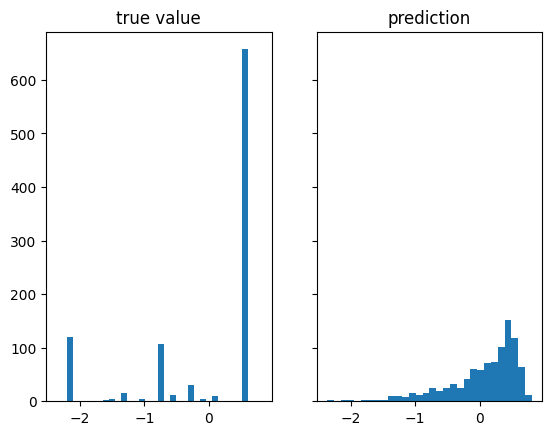

In [6]:
model = Sequential([
    Dense(10, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='relu'),
    Dense(1),
]) 
model.compile(optimizer='adam', 
              loss="mse", 
              metrics=['accuracy']) 

x=np.array(data.drop(columns=["article_id","user_id","correctness"]))
xu=utils.to_categorical(raw_data["user_id"])
xa=utils.to_categorical(raw_data["article_id"])
x=np.concatenate((x,xu,xa),axis=1)
y=np.array(data["correctness"])

train_set,test_set=trainORtest(x.shape[0])

history=model.fit(x[train_set], y[train_set],validation_split=.2,epochs=25,verbose=0)

test_pred=model.predict(x[test_set])
print("r2:",(r2_score(y[test_set],test_pred)))

plot_history(history)
plot_distrubution(y[test_set],test_pred)

predict **confidence** (continuous without resample)

31/31 [==============================] - 0s 864us/step
r2 0.3368732438668349


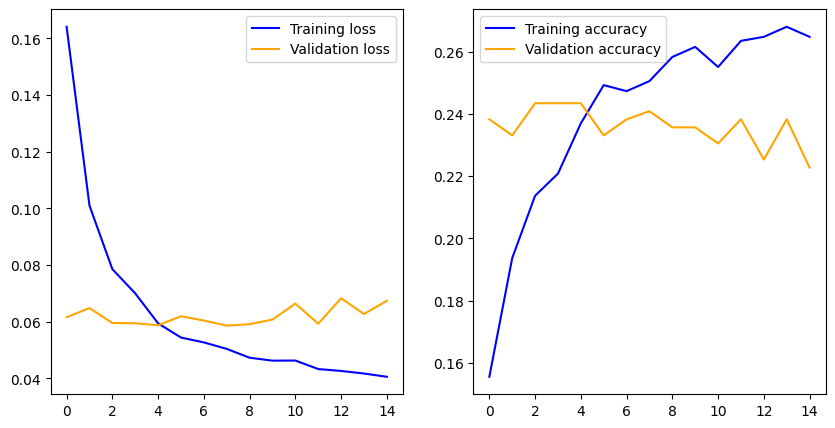

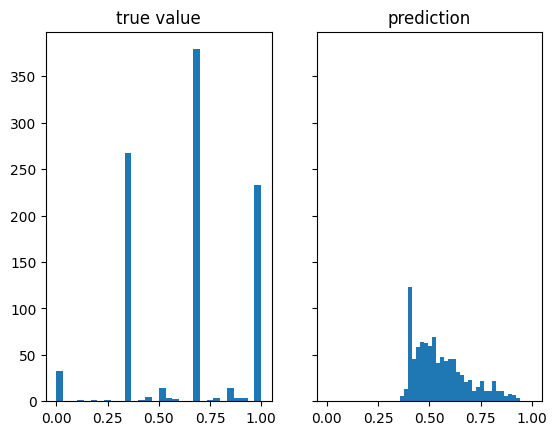

In [7]:
model = Sequential([
    Dense(10, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='relu'),
    Dense(1),
]) 
model.compile(optimizer='adam', 
              loss="mse", 
              metrics=['accuracy']) 


data=raw_data.copy()
data=(data-data.min())/(data.max()-data.min())
x=np.array(data.drop(columns=["article_id","user_id","confidence"]))
x=np.concatenate((x,xu,xa),axis=1)
y=np.array(data["confidence"])

train_set,test_set=trainORtest(x.shape[0])

history=model.fit(x[train_set], y[train_set],validation_split=.2,epochs=15,verbose=0)
test_pred=model.predict(x[test_set])
print("r2",(r2_score(y[test_set],test_pred)))

plot_history(history)
plot_distrubution(y[test_set],test_pred)

predict **confidence** (categorical with resample)

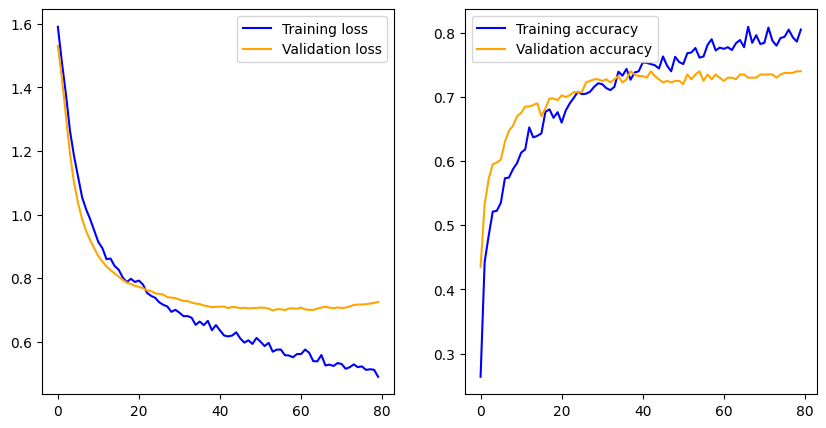

48/48 [==============================] - 0s 806us/step
r2 0.5496688741721855


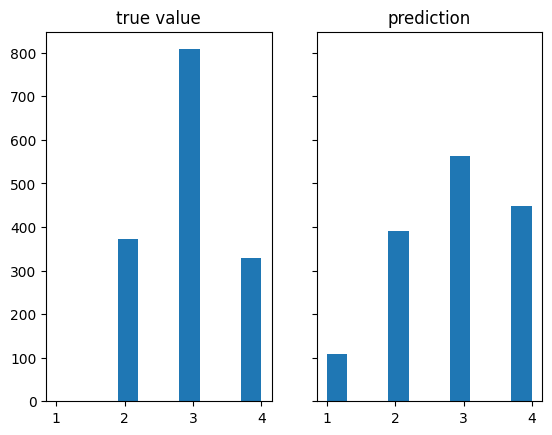

In [8]:
model = Sequential([
    Dense(10, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')    
]) 
model.compile(optimizer='adam', 
              loss="categorical_crossentropy",
              metrics=['accuracy']) 

def themodel(outcome):
    data=data_zscore[raw_data[outcome]%1==0]
    x=np.array(data.drop(columns=["article_id","user_id",outcome]))
    xu=utils.to_categorical(raw_data[raw_data[outcome]%1==0]["user_id"])
    xa=utils.to_categorical(raw_data[raw_data[outcome]%1==0]["article_id"])
    x=np.concatenate((x,xu,xa),axis=1)
    y=np.array(raw_data[raw_data[outcome]%1==0][outcome])
    y_categorical=utils.to_categorical(y)

    #resample
    cr=chooser(y,500)
    ccr=list(set(range(data.shape[0]))-set(cr))
    train_set,test_set=(cr,ccr)

    history=model.fit(x[train_set], y_categorical[train_set],validation_split=.2,epochs=80,verbose=0)
    plot_history(history)

    #prediction
    test_pred=model.predict(x[test_set])
    print("r2",accuracy_score(y[test_set],[np.argmax(x) for x in test_pred]))
    plot_distrubution(y[test_set],[np.argmax(x) for x in test_pred],b=10)

    return model

themodel("confidence")

change view

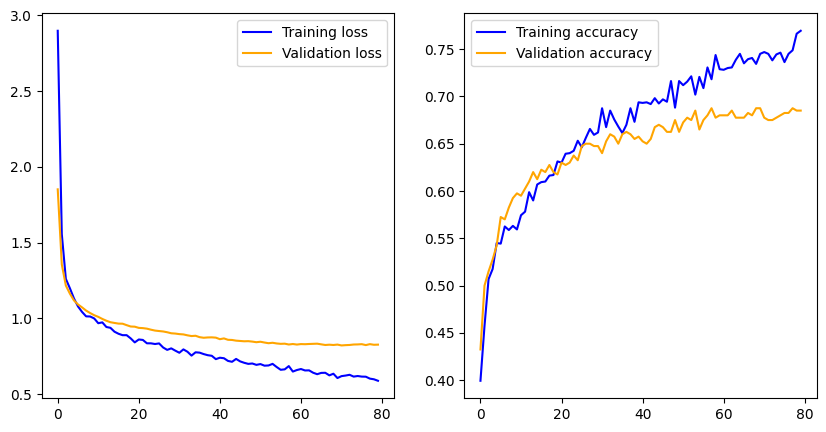

46/46 [==============================] - 0s 1ms/step
r2 0.49410131852879946


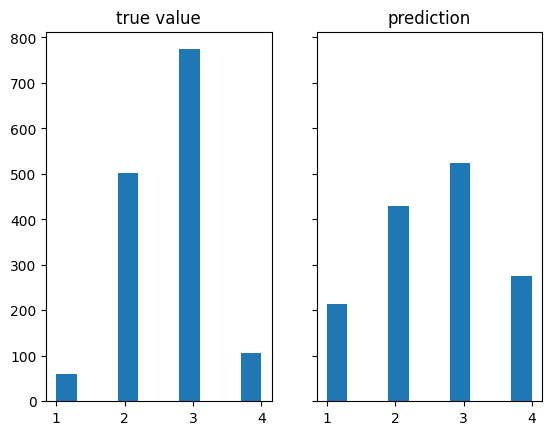

In [9]:
themodel("change_view")